## 機械学習フロー

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns

## 【問題1】クロスバリデーション

In [11]:
df = pd.read_csv("application_train.csv")

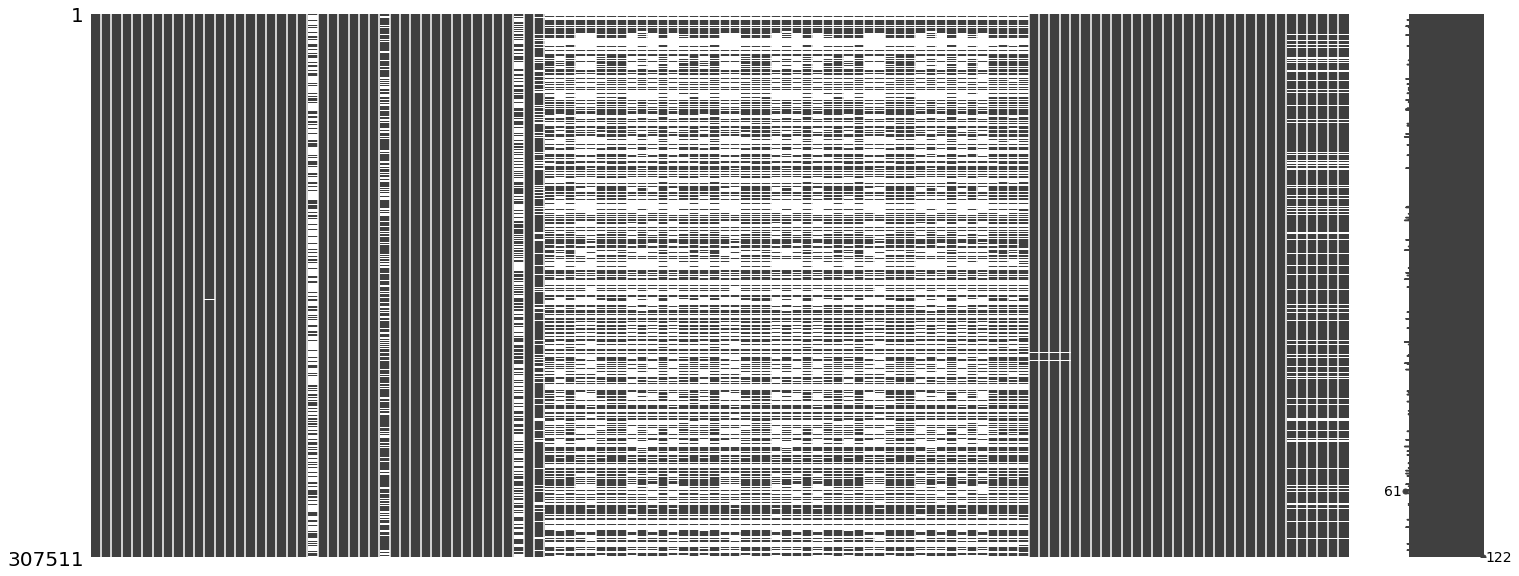

In [3]:
import missingno as msno
msno.matrix(df);

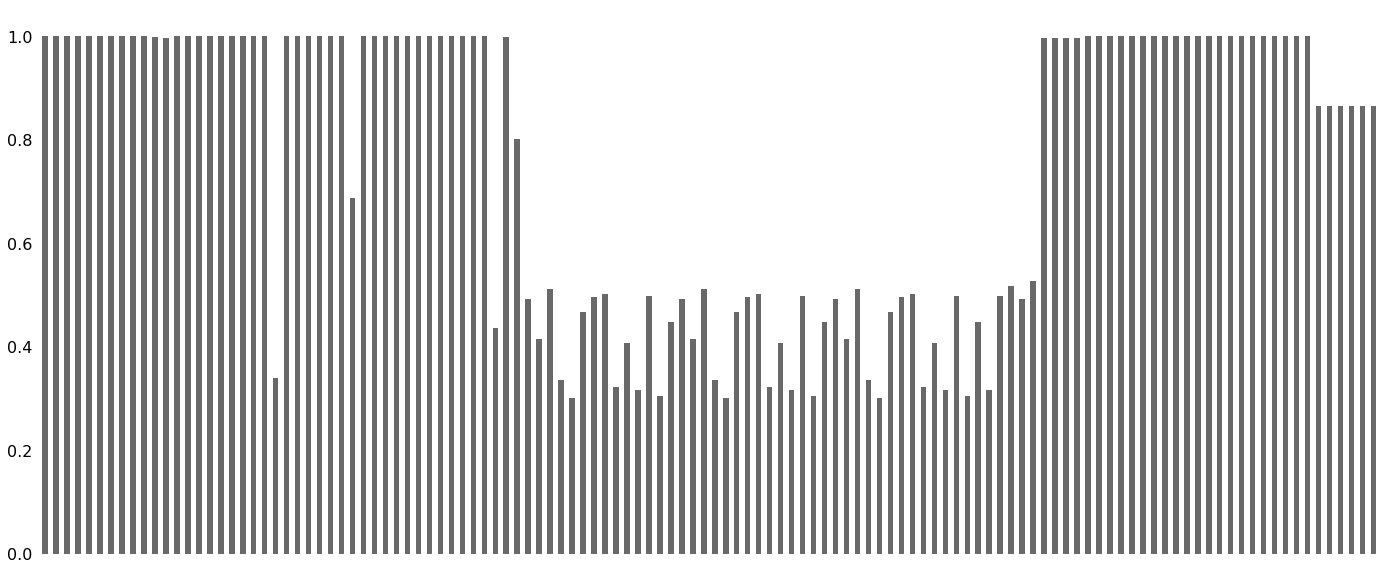

In [4]:
msno.bar(df);

In [5]:
df_s = np.abs(df.corr().loc[: , "TARGET"])
df_s.head()

SK_ID_CURR          0.002108
TARGET              1.000000
CNT_CHILDREN        0.019187
AMT_INCOME_TOTAL    0.003982
AMT_CREDIT          0.030369
Name: TARGET, dtype: float64

In [6]:
df_s = df_s.sort_values(ascending = False).head(11)

In [23]:
y = df.loc[: , "TARGET"]
x0 = df.loc[: , ["EXT_SOURCE_1", "EXT_SOURCE_2","EXT_SOURCE_3" , "DAYS_BIRTH"]]
X1 = pd.concat([x0 , y] , axis = 1)
X1 = X1.dropna(how = "any")
X = X1.iloc[: , :4].values
y = X1.iloc[: , 4].values

In [8]:
#クロスバリデーション
from sklearn.model_selection import KFold
kf_5 = KFold(n_splits = 5 , random_state=None, shuffle=False)
kf_5.get_n_splits(X)
for train_index , test_index in kf_5.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train , X_test = X[train_index] , X[test_index]
    y_train , y_test = y[train_index] , y[test_index]

TRAIN: [ 21918  21919  21920 ... 109586 109587 109588] TEST: [    0     1     2 ... 21915 21916 21917]
TRAIN: [     0      1      2 ... 109586 109587 109588] TEST: [21918 21919 21920 ... 43833 43834 43835]
TRAIN: [     0      1      2 ... 109586 109587 109588] TEST: [43836 43837 43838 ... 65751 65752 65753]
TRAIN: [     0      1      2 ... 109586 109587 109588] TEST: [65754 65755 65756 ... 87669 87670 87671]
TRAIN: [    0     1     2 ... 87669 87670 87671] TEST: [ 87672  87673  87674 ... 109586 109587 109588]


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
lr = LogisticRegression()
lr.fit(X_train , y_train)
y_pred = lr.predict(X_test)
print(lr.score(X_test , y_test))
print(roc_auc_score(y_test , y_pred))

0.9278642149929278
0.5


In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

knc = KNeighborsClassifier()
lr = LogisticRegression()
svc = SVC()
tree = DecisionTreeClassifier()
forest = RandomForestClassifier()

/Users/hayashikentaro/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [11]:
from sklearn.model_selection import cross_val_score

models = []
models.append(("最近傍法" , knc))
models.append(("ロジスティック回帰" , lr))
#models.append(("SVM" , svc))
models.append(("決定木" , tree))
models.append(("ランダムフォレスト" ,  forest))

results = []
names = []
for name , model in models:
    result = cross_val_score(model , X_train , y_train , cv = kf_5  , scoring = "roc_auc")
    names.append(name)
    results.append(result)
    
for i in range(len(names)):
    print(names[i],results[i].mean())

最近傍法 0.535054784420565
ロジスティック回帰 0.5766310206465302
決定木 0.5354570177978496
ランダムフォレスト 0.6424384497661961


## 【問題2】グリッドサーチ

In [12]:
from sklearn.model_selection import GridSearchCV

#LogisticRegression(penalty="L1" or 'L2')
tree = RandomForestClassifier()
#parameters = {"C" : [0.1 , 1 , 10 , 100]}
parameters = {"n_estimators" : [50]}

clf = GridSearchCV(estimator = tree , param_grid = parameters , cv = kf_5 , scoring = "roc_auc")
clf.fit(X , y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [13]:
clf.best_score_

0.6876105359240331

In [14]:
clf.best_params_

{'n_estimators': 50}

## 【問題3】Kernelからの調査

In [15]:
#KaggleのKernelから様々なアイデアを見つけ出して、列挙してください。

・欠損値の補完

・別のツールの使用（LightGBM）

・新たな特徴量を作る

## 【問題4】高い汎化性能のモデル作成


## 欠損値を０に補完する

In [35]:
y = df.loc[: , "TARGET"]
x0 = df.loc[: , ["EXT_SOURCE_1", "EXT_SOURCE_2","EXT_SOURCE_3" , "DAYS_BIRTH"]]
#from sklearn.preprocessing import Imputer
#imp = Imputer(strategy = "median" , axis = 0)
#imp.fit(x0)
#imp.transform(x0)

X1 = pd.concat([x0 , y] , axis = 1)
#X1 = X1.dropna(how = "any")
X = X1.iloc[: , :4]
y = X1.iloc[: , 4].values
X = X.fillna(0).values
#X = X.fillna(X.median()).values
#imp.fit(X)
#imp.transform(X)

In [17]:
from sklearn.model_selection import KFold
kf_5 = KFold(n_splits = 5 , random_state=None, shuffle=False)
kf_5.get_n_splits(X)
for train_index , test_index in kf_5.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train , X_test = X[train_index] , X[test_index]
    y_train , y_test = y[train_index] , y[test_index]

TRAIN: [ 61503  61504  61505 ... 307508 307509 307510] TEST: [    0     1     2 ... 61500 61501 61502]
TRAIN: [     0      1      2 ... 307508 307509 307510] TEST: [ 61503  61504  61505 ... 123002 123003 123004]
TRAIN: [     0      1      2 ... 307508 307509 307510] TEST: [123005 123006 123007 ... 184504 184505 184506]
TRAIN: [     0      1      2 ... 307508 307509 307510] TEST: [184507 184508 184509 ... 246006 246007 246008]
TRAIN: [     0      1      2 ... 246006 246007 246008] TEST: [246009 246010 246011 ... 307508 307509 307510]


In [18]:
models = []
models.append(("最近傍法" , knc))
models.append(("ロジスティック回帰" , lr))
#models.append(("SVM" , svc))
models.append(("決定木" , tree))
models.append(("ランダムフォレスト" ,  forest))

results = []
names = []
for name , model in models:
    result = cross_val_score(model , X_train , y_train , cv = kf_5  , scoring = "roc_auc")
    names.append(name)
    results.append(result)
    
for i in range(len(names)):
    print(names[i],results[i].mean())

最近傍法 0.5494870900069332
ロジスティック回帰 0.5826220515440108
決定木 0.6176092006812388
ランダムフォレスト 0.6196148584131299


## 欠損値を０に補完
## LightGBMを使用
## 特徴値をTARGETとの相関の高い上位１０使用

In [19]:
df_s

TARGET                         1.000000
EXT_SOURCE_3                   0.178919
EXT_SOURCE_2                   0.160472
EXT_SOURCE_1                   0.155317
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
Name: TARGET, dtype: float64

In [31]:
X_1 = df.loc[: , ["EXT_SOURCE_3","EXT_SOURCE_2" , "EXT_SOURCE_1" , "DAYS_BIRTH" , 
                       "REGION_RATING_CLIENT_W_CITY" , "REGION_RATING_CLIENT" ,"DAYS_LAST_PHONE_CHANGE" , 
                         "DAYS_ID_PUBLISH" , "REG_CITY_NOT_WORK_CITY" , "FLAG_EMP_PHONE"]]
X_1 = X_1.fillna(0)

In [21]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.2, random_state=0)
lgb_train = lgb.Dataset(data = X_train , label = y_train)
lgb_test = lgb.Dataset(data = X_test , label = y_test)

/Users/hayashikentaro/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [22]:
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.01, 'num_leaves': 48, 'num_iteration': 5000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1}
model = lgb.train(params, lgb_train, valid_sets = lgb_test , early_stopping_rounds = 150, verbose_eval = 200)

/Users/hayashikentaro/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 150 rounds
[200]	valid_0's auc: 0.728606
[400]	valid_0's auc: 0.731109
[600]	valid_0's auc: 0.731806
[800]	valid_0's auc: 0.731897
Early stopping, best iteration is:
[844]	valid_0's auc: 0.731901


In [23]:
#cross_val_score( lgb , X_train, y_train , cv = kf_5  , scoring = "roc_auc")

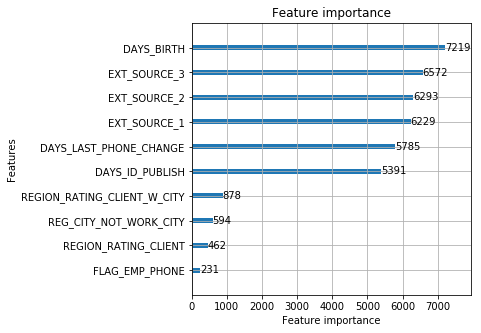

In [24]:
lgb.plot_importance(model, figsize=(5, 5));

In [ ]:
from sklearn.model_selection import GridSearchCV

model = lgb.LGBMClassifier()
parameters = {"N_estimators" : [1 , 10 ,50 ,100 ] , "Max_depth" : [3 , 5 , 8]}

clf = GridSearchCV(estimator = model , param_grid = parameters , cv = kf_5 , scoring = "roc_auc")
clf.fit(X_1 , y)

In [ ]:
clf.best_score_

In [ ]:
clf.best_params_

In [ ]:
lgb.plot_importance(model, figsize=(5, 5));

## 欠損値を０に補完
## LightGBMを使用
## 特徴値をTARGETとの相関の高い上位4使用

In [ ]:
X = pd.DataFrame(X).fillna(0)
X.columns =["EXT_SOURCE_1", "EXT_SOURCE_2","EXT_SOURCE_3" , "DAYS_BIRTH"]

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lgb_train = lgb.Dataset(data = X_train , label = y_train)
lgb_test = lgb.Dataset(data = X_test , label = y_test)

In [ ]:
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.01, 'num_leaves': 48, 'num_iteration': 5000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1}
model = lgb.train(params, lgb_train, valid_sets = lgb_test , early_stopping_rounds = 150, verbose_eval= 200)
#print(result = cross_val_score(model , X_train, y_train , cv = kf_5  , scoring = "roc_auc"))

In [ ]:
#lgb.plot_importance(model, figsize=(5, 5));

In [ ]:
from sklearn.model_selection import GridSearchCV

model = lgb.LGBMClassifier()
parameters = {"N_estimators" : [ 1 , 10 ,50 , 100] , "Max_depth" : [3 , 5 , 8]}

clf = GridSearchCV(estimator = model , param_grid = parameters , cv = kf_5 , scoring = "roc_auc")
clf.fit(X , y)

In [ ]:
clf.best_score_

In [ ]:
clf.best_params_

In [30]:
df['DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['DAYS_EMPLOYED_PERCENT']
df_s = np.concatenate([df_s , df['DAYS_EMPLOYED_PERCENT']])
X_1 = df.loc[: , ["EXT_SOURCE_3","EXT_SOURCE_2" , "EXT_SOURCE_1" , "DAYS_BIRTH" , 
                       "REGION_RATING_CLIENT_W_CITY" , "REGION_RATING_CLIENT" ,"DAYS_LAST_PHONE_CHANGE" , 
                         "DAYS_ID_PUBLISH" , "REG_CITY_NOT_WORK_CITY" , "FLAG_EMP_PHONE" , "DAYS_EMPLOYED_PERCENT"]]
X_1 = X_1.fillna(0)

NameError: name 'df_s' is not defined

In [ ]:
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 
          'learning_rate': 0.01, 'num_leaves': 48, 'num_iteration': 5000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1}
model = lgb.train(params, lgb_train, valid_sets = lgb_test , early_stopping_rounds = 150, verbose_eval= 200)
#print(result = cross_val_score(model , X_train, y_train , cv = kf_5  , scoring = "roc_auc"))

In [ ]:
from sklearn.model_selection import GridSearchCV

model = lgb.LGBMClassifier()
parameters = {"N_estimators" : [ 1 , 10 ,50 , 100] , "Max_depth" : [3 , 5 , 8]}

clf = GridSearchCV(estimator = model , param_grid = parameters , cv = kf_5 , scoring = "roc_auc")
clf.fit(X , y)

In [ ]:
clf.best_score_

In [ ]:
clf.best_params_

## 【問題5】最終的なモデルの選定

In [129]:
df_test = pd.read_csv("application_test.csv")

In [130]:
X_t = df_test.loc[: , ["SK_ID_CURR", "EXT_SOURCE_3","EXT_SOURCE_2" , "EXT_SOURCE_1" , "DAYS_BIRTH" , 
                       "REGION_RATING_CLIENT_W_CITY" , "REGION_RATING_CLIENT" ,"DAYS_LAST_PHONE_CHANGE" , 
                         "DAYS_ID_PUBLISH" , "REG_CITY_NOT_WORK_CITY" , "FLAG_EMP_PHONE"]]
X_t = X_t.fillna(0)

In [131]:
X_SK_ID_CURR = X_t.iloc[: , 0]
X_t = X_t.drop("SK_ID_CURR" , axis = 1)

In [132]:
X_t = X_t.values

In [133]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_1 , y)
#X_std = lgb.transform(X , y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [134]:
y_test_pred = clf.predict_proba(X_t)

In [135]:
X_SK_ID_CURR.shape

(48744,)

In [136]:
X_1.shape

(307511, 10)

In [137]:
y.shape

(307511,)

In [138]:
y_test_pred = pd.DataFrame(data = y_test_pred)
X_SK_ID_CURR = pd.DataFrame(data = X_SK_ID_CURR)

In [139]:
X_SK_ID_CURR = X_SK_ID_CURR.join( y_test_pred)
X_SK_ID_CURR

,SK_ID_CURR,0,1
0,100001,0.968242,0.031758
1,100005,0.916629,0.083371
2,100013,0.972271,0.027729
3,100028,0.957191,0.042809
4,100038,0.863632,0.136368
5,100042,0.935490,0.064510
6,100057,0.977606,0.022394
7,100065,0.957269,0.042731
8,100066,0.987527,0.012473
9,100067,0.802888,0.197112


In [140]:
X_SK_ID_CURR = X_SK_ID_CURR.iloc[: , [0 , 2]]

In [141]:
X_SK_ID_CURR.columns = ["SK_ID_CURR" , "TARGET"]

In [143]:
X_SK_ID_CURR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 2 columns):
SK_ID_CURR    48744 non-null int64
TARGET        48744 non-null float64
dtypes: float64(1), int64(1)
memory usage: 761.7 KB


In [144]:
#X_SK_ID_CURR.to_csv("sprint1_test2.csv" )

## 最終的なスコア

スコア : 0.72589

最終的にはlightgbmを使い、TARGETとの相関性の高い上位１０個を学習させたデータを使用した

新たな特徴量を作り使用してみたが、あまり結果は出ず。新たな特徴量を生み出すことに今後はさらに追求し挑戦していきたい